#### Advanced Statistics for Data Science (Spring 2023)
# Home Assignment 5
#### Topics:
- Model/Variable Selection
- Violations of Assumptions

#### Due: 20/06/2022 by 18:30

#### Instructions:
- Write your name, Student ID, and date in the cell below. 
- Submit a copy of this notebook with code filled in the relevant places as the solution of coding excercises.
- For theoretic excercises, you can either write your solution in the notebook using $\LaTeX$ or submit additional notes.

<hr>
<hr>



**Name**: Loten Noy, Gil-ad Katz 

**Student ID**: 201466349, 313591851

**Date**: 27/05/2023

$\renewcommand{\Id}{{\mathbf{I}}}  
\renewcommand{\SSE}{\mathsf{SSE}}
\renewcommand{\SSR}{\mathsf{SSR}}
\renewcommand{\MSE}{\mathsf{MSE}}
\renewcommand{\simiid}{\overset{iid}{\sim}}
\renewcommand{\ex}{\mathbb E}
\renewcommand{\var}{\mathrm{Var}}
\renewcommand{\Cov}[2]{{\mathrm{Cov}  \left(#1, #2 \right)}}
\renewcommand{\one}[1]{\mathbf 1 {\left\{#1\right\}}}
\renewcommand{\SE}[1]{\mathrm{SE} \left[#1\right]}
\renewcommand{\reals}{\mathbb R}
\renewcommand{\Ncal}{\mathcal N}
\renewcommand{\abs}[1]{\ensuremath{\left\vert#1\right\vert}}
\renewcommand{\rank}{\operatorname{rank}}
\renewcommand{\tr}{\operatorname{Tr}}
\renewcommand{\diag}{\operatorname{diag}}
\renewcommand{\sign}{\operatorname{sign}}$


<hr>
<hr>

## Problem 1 (Variable Selection)

Use life expectancy dataset from class. Remove entries with missing values; remove the categorical varaible ``Country`` and transform the categorical varaible ``Status``; see provided function. 

1. Write the function ``backward_select`` (prototype below). Make sure that your function prints $R^2$ and F-test $p$-value of each candidate model it iterates through in the process.
Apply it on the house prices dataset and report the resulting model.
2. Write a function that receives as an input a set of predictors and the response and evaluates the leave-one-out error (n-fold cross validation). What is the leave-one-out error of the model you found in 1?
3. Consider the predictors ``infant_deaths``, ``BMI``, ``Status_dummy``, ``Alcohol``, ``Diphtheria``, ``Year``, ``HIV/AIDS`` . Go over all $2^7$ models. Evaluate $R^2$, AIC, BIC, $C_p$, and leave-one-out CV-error for every model and print the results. Report on the models with lowest AIC, BIC, CV-error, $C_p$. 

Hint: for 1, modify the ``forward_select`` function from class. You may also use the function ``sm.stats.anova_lm(smaller_model, larger_model)`` to compare two ``statsmodels`` models. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
def read_and_prepare_life_expectancy_data(path_to_csv_file):
    """
    1. Load dataset from csv file
    2. Remove entries with missing values
    3. Remove spaces from column names
    4. Add a dummy varaible based on `Status` columns
    5. Remove non-numerical variables `Status` and `Country`
    """
    data = pd.read_csv(path_to_csv_file).dropna()
    data.columns = ["_".join(c.split()) for c in data.columns]
    data['Status_dummy'] = data['Status'].apply(lambda x : 1 if x=='Developing' else 0)
    non_numeric_vars = ["Status", "Country"]
    data_numeric = data.drop(columns = non_numeric_vars).dropna()
    data_country = data[['Country']]
    return data_numeric.reset_index(drop=True)

In [3]:
df = read_and_prepare_life_expectancy_data('data/Life Expectancy Data.csv')
df.head()

,Year,Life_expectancy,Adult_Mortality,infant_deaths,Alcohol,percentage_expenditure,Hepatitis_B,Measles,BMI,under_five_deaths,...,Total_expenditure,Diphtheria,HIV,GDP,Population,thinness_1_19_years,thinness_5_9_years,Income_composition_of_resources,Schooling,Status_dummy
0,2015,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,...,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1,1
1,2014,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,...,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0,1
2,2013,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,...,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9,1
3,2012,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,...,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8,1
4,2011,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,...,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5,1


In [4]:
import statsmodels.formula.api as smf
import scipy

def backward_select(data, response, sig_level=.05):
       """Linear model designed by forward selection.

       Parameters:
       -----------
       data: pandas DataFrame with all possible predictors and response

       response: string, name of response column in data

       sig_level:  significance level for F-test
       
       Returns:
       --------
       model: an "optimal" fitted statsmodels linear model
              with an intercept selected by backward selection
              evaluated by R-squared and F-test for extra sum of squares
       """
       n = len(data)
       
       remaining = [c for c in data.columns if not c == response]
       
       varst = ' + '.join(remaining)
       formula = f"{response} ~ {varst} + 1"
       fitted = smf.ols(formula, data).fit()
       SS_prev = fitted.ssr
       Ftest_pval = 1

       itr = 0
       while remaining and Ftest_pval > sig_level:
              itr += 1
              R2_without_candidates = []
              SS_without_candidates = {}
              for candidate in remaining:
                     varst = ' + '.join(remaining).replace(candidate, '')
                     formula = f"{response} ~ {varst} + 1"
                     fitted = smf.ols(formula, data).fit()
                     
                     R2 = fitted.rsquared
                     SS_candidate = fitted.ssr
                     R2_without_candidates.append((R2, candidate))
                     SS_without_candidates[candidate] = SS_candidate

              R2_without_candidates.sort()
              worst_new_R2, worst_candidate = R2_without_candidates.pop()
              SS_new = SS_without_candidates[worst_candidate]
              f = (SS_new - SS_prev) / (SS_prev / (n-len(remaining)))
              Ftest_pval = scipy.stats.f.sf(f, dfn=1, dfd=n-len(remaining))
              SS_prev = SS_new
              
              print(f"Step {itr}: {worst_candidate} (pvalue = {Ftest_pval}, R2 = {worst_new_R2}))")
              
              if Ftest_pval > sig_level:
                     remaining.remove(worst_candidate)
              else:
                     print(f"Do not remove {worst_candidate}, total {len(remaining)} variables left")
                     

       formula = f"{response} ~ {' + '.join(remaining)} + 1"
       model = smf.ols(formula, data).fit()
       return model

In [5]:
model = backward_select(df, 'Life_expectancy')

print("\n" + model.model.formula)

Step 1: thinness_1_19_years (pvalue = 0.9118619722227432, R2 = 0.8385751627787918))
Step 2: Population (pvalue = 0.7228857166430896, R2 = 0.8385627055389226))
Step 3: Hepatitis_B (pvalue = 0.46732472443200324, R2 = 0.8385103901350186))
Step 4: GDP (pvalue = 0.38732536995418687, R2 = 0.8384364015323243))
Step 5: Measles (pvalue = 0.35352972160441065, R2 = 0.8383511935389814))
Step 6: Polio (pvalue = 0.2943540666077895, R2 = 0.8382423421545568))
Step 7: thinness_5_9_years (pvalue = 0.046429901471560835, R2 = 0.8378493790478743))
Do not remove thinness_5_9_years, total 14 variables left

Life_expectancy ~ Year + Adult_Mortality + infant_deaths + Alcohol + percentage_expenditure + BMI + under_five_deaths + Total_expenditure + Diphtheria + HIV + thinness_5_9_years + Income_composition_of_resources + Schooling + Status_dummy + 1


In [6]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

def loocv_linear(data, response, predictors):    
    X = data[predictors].values
    X = sm.add_constant(X)  # Add a constant column for the intercept
    y = data[response]
        
    beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
    y_hat =  X @ beta_hat
        
    residuals = y - y_hat
    H = X @ np.linalg.inv(X.T @ X) @ X.T
    
    return np.sum((residuals / (1 - np.diag(H)))**2)


In [7]:
predictors = [
    'Year',
    'Adult_Mortality',
    'infant_deaths',
    'Alcohol',
    'percentage_expenditure',
    'BMI',
    'under_five_deaths',
    'Total_expenditure',
    'Diphtheria',
    'HIV',
    'thinness_5_9_years',
    'Income_composition_of_resources',
    'Schooling',
    'Status_dummy'
]

loocv_linear(df, 'Life_expectancy', predictors)

21113.401763897502

In [12]:
import itertools

def run_experiment(data, response, predictors, verbose=False):
    results = pd.DataFrame(columns=['predictors' ,'r_squared', 'aic', 'bic', 'Cp', 'loocv'])
    for i in range(1, len(predictors) + 1):  # to get all lengths: 0 to 3
        for subset in itertools.combinations(predictors, i):
            varst = ' + '.join(subset)
            formula = f"{response} ~ {varst} + 1"
            fitted = smf.ols(formula, data).fit()
            r_squared = fitted.rsquared
            aic = fitted.aic
            bic = fitted.bic
            Cp = fitted.ssr / fitted.mse_resid - len(df) + 2 * len(predictors)
            loocv = loocv_linear(data, response, list(subset))
            results = pd.concat(
                [
                    results, 
                    pd.DataFrame(
                        [[list(subset), r_squared, aic, bic, Cp, loocv]], 
                        columns=['predictors' ,'r_squared', 'aic', 'bic', 'Cp', 'loocv']
                    )
                ]
            )
            
            if verbose:
                print(list(subset))
                print(f"R-squared: {r_squared}")
                print(f"AIC: {aic}")
                print(f"BIC: {bic}")
                print(f"Cp: {Cp}")
    
    return results.reset_index(drop=True)
    


In [13]:
response = 'Life_expectancy'
predictors = ['infant_deaths', 'BMI', 'Status_dummy', 'Alcohol', 'Diphtheria', 'Year', 'HIV']

results = run_experiment(df, response, predictors)

In [16]:
print('Best model by R-squared')
print(results.sort_values(by='r_squared', ascending=False).head(1).to_string(index=False))

print('\nBest model by AIC')
print(results.sort_values(by='aic', ascending=True).head(1).to_string(index=False))

print('\nBest model by BIC')
print(results.sort_values(by='bic', ascending=True).head(1).to_string(index=False))

print('\nBest model by Cp')
print(results.sort_values(by='Cp', ascending=True).head(1).to_string(index=False))

print('\nBest model by loocv')
print(results.sort_values(by='loocv', ascending=True).head(1).to_string(index=False))

Best model by R-squared
                                                        predictors  r_squared         aic          bic  Cp        loocv
[infant_deaths, BMI, Status_dummy, Alcohol, Diphtheria, Year, HIV]   0.641761 10173.01479 10216.278185 6.0 46240.569248

Best model by AIC
                                                  predictors  r_squared          aic          bic  Cp       loocv
[infant_deaths, BMI, Status_dummy, Alcohol, Diphtheria, HIV]   0.641721 10171.199747 10209.055217 7.0 46192.89559

Best model by BIC
                                   predictors  r_squared         aic          bic  Cp        loocv
[BMI, Status_dummy, Alcohol, Diphtheria, HIV]   0.640566 10174.50739 10206.954936 8.0 46288.781163

Best model by Cp
                                                        predictors  r_squared         aic          bic  Cp        loocv
[infant_deaths, BMI, Status_dummy, Alcohol, Diphtheria, Year, HIV]   0.641761 10173.01479 10216.278185 6.0 46240.569248

Best model by

## Problem 2 (Selecting Order of Regression using Cross-Validation)

Consider the dataset ``AnneFrank.csv``, describing the number of searches of the term "Anne Frank" by hour over several days in February 2022. The cell below contains code you should use to arrange the data by hours. 

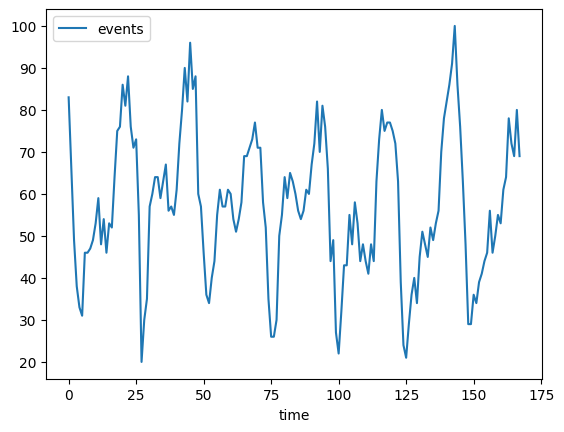

In [17]:
path = "data/AnneFrank.csv"
AnneFrank = pd.read_csv(path, header=1, names=['time', 'events'])
AnneFrank['date'] = pd.to_datetime(AnneFrank.time)
AnneFrank['time'] = AnneFrank['date'].astype(int) / 3600000000000
AnneFrank['time'] = AnneFrank['time'] - AnneFrank['time'].min()
AnneFrank.plot(x='time', y='events'); 

In [18]:
AnneFrank.head()

,time,events,date
0,0.0,83,2022-02-14 09:00:00
1,1.0,66,2022-02-14 10:00:00
2,2.0,49,2022-02-14 11:00:00
3,3.0,38,2022-02-14 12:00:00
4,4.0,33,2022-02-14 13:00:00


In this question you will fit a model to the response based on $2p+1$ predictors of the form:
$$
\begin{align}
x_1 = [1,~\ldots~,1]
\end{align}
$$
$$
\begin{align}
x_{2k} & = \sin(2 \pi \cdot k \cdot t / 48) \\
x_{2k+1} & = \cos(2 \pi \cdot k \cdot t / 48), \qquad k=1,\ldots,p
\end{align}
$$
You will then use the selected model to predict the number of events in future times. 

1. Write a function ``generate_Z`` that recieves as inputs a vector of time indices (representing hours) ``t`` and ``p``. The function returns the design matrix $Z$ of size $n \times (2p+1)$, where $n$ is the length of ``t``.
2. For each $p=1,\ldots,30$, fit a linear model to ``events`` based on $Z$ you obtain from ``generate_Z`` and evalaute its leave-one-out CV error. Plot the CV error versus $p$. 
3. Report on the model with the lowest CV error; plot its response over time along with the original response in the figure above. 
4. Using the model you found in 3, predict the number of event at times $t=168.\ldots,190$. Plot your prediction over time in the same figure as above, i.e., interpolate the response curve to future value. 
5. For each $t$ in 4, construct a 0.95 prediction interval of your prediction of $y_t$, $t=168,\ldots,190$. Plot the upper and lower limits of this interval over time (these lines define a prediction band). Here, you may ignore the danger of inference based on the t distribution after applying a model selection procedure. 

Hints: (2) In order to evalaute the CV error, you'll need the hat matrix (which you can get directly from Z) and the residuals in the LS fit (which you can get from the ``resid`` property of the fitted model object returned by ``statsmodels.api.OLS.fit``). (4) you can use the function ``predict`` of the fitted model object by passing new predictors that you generate using ``generate_Z``. For (5), $s^2$ is given by the property ``mse_resid`` (or ``ssr`` divided by the number of degrees of freedom). Also note that the number of degrees of freedom is $2p+1$ where $p$ is the number you found in 3. 

In [36]:
def generate_Z(t, p):
    """
    Args:
    ----
    t:   vector of time samples (length n)
    p:   number of frequencies (overal 2p+1 predictors)
    
    Returns:
    --------
    Z:  design matrix of size (n, 2p+1)
    """
    
    # Your code goes here
    
    Z = np.zeros((len(t), 2*p+1+1))
    Z[:, 1] = 1
    for k in range(1, p+1):
        Z[:, 2*k] = np.sin(2*np.pi * k*t/48)
        Z[:, 2*k+1] = np.cos(2*np.pi * k*t/48)

    return Z[:, 1:]

In [75]:
loo_cv = []
for p in range(1, 29):
    Z = generate_Z(AnneFrank['time'], p)
    model = sm.OLS(AnneFrank['events'], Z).fit()
    cols = [f'x{i+1}' for  i in range(Z.shape[1])]
    Z_df = pd.DataFrame(Z, columns=cols)
    data = pd.concat([Z_df, AnneFrank['events']], axis=1)
    loo_cv.append((p, loocv_linear(data, 'events', cols)))

<Axes: xlabel='p'>

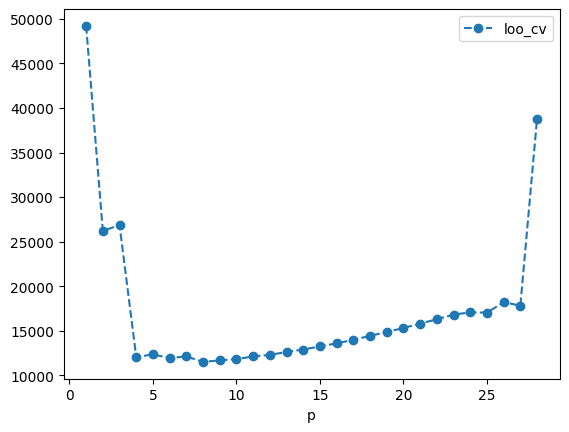

In [76]:
# plot the loo_cv
loo_cv_scores_df = pd.DataFrame(loo_cv, columns=['p', 'loo_cv'])
loo_cv_scores_df.plot(x='p', y='loo_cv', marker='o', linestyle='--')

In [77]:
import matplotlib.pyplot as plt
loo_cv_scores_df.sort_values(by='loo_cv', ascending=True).head(1)

,p,loo_cv
7,8,11498.432094


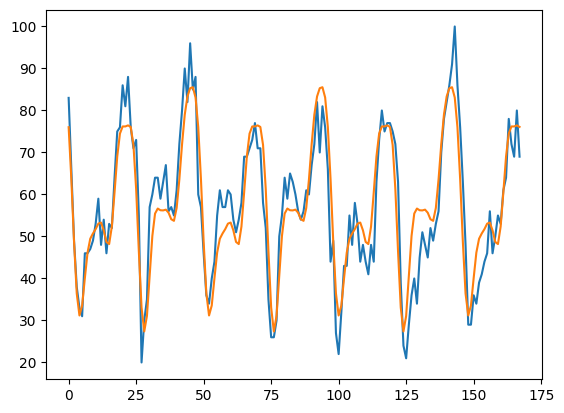

In [78]:
p = 8 # lowest CV error
Z = generate_Z(AnneFrank['time'], p)
model = sm.OLS(AnneFrank['events'], Z).fit()
y_hat = model.predict(Z)
plt.plot(AnneFrank['time'], AnneFrank['events'], label='events')
plt.plot(AnneFrank['time'], y_hat, label='y_hat');

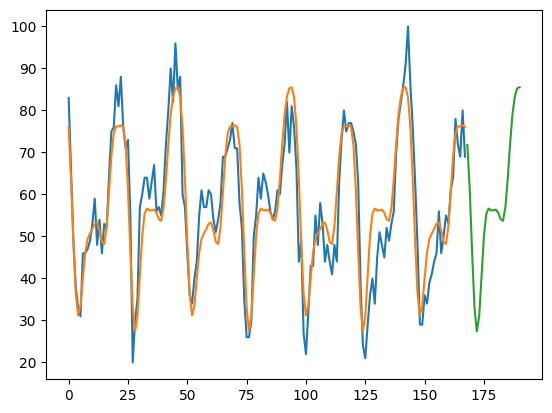

In [82]:
p = 8 # lowest CV error
new_time = np.arange(168, 191)
Z = generate_Z(new_time, p)
# model = sm.OLS(AnneFrank['events'], Z).fit()
y_hat_new = model.predict(Z)
plt.plot(AnneFrank['time'], AnneFrank['events'], label='events')
plt.plot(AnneFrank['time'], y_hat, label='y_hat')
plt.plot(new_time, y_hat_new, label='y_hat_new');

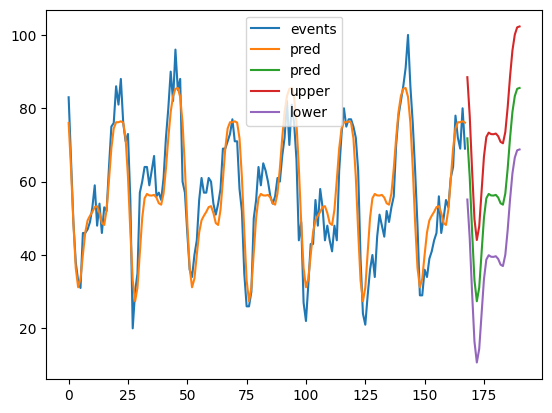

In [86]:
# For each t above, t=168,...,190, construct a 0.95 prediction interval of your prediction of y_t. Plot the upper and lower limits of this interval over time (these lines define a prediction band). Here, you may ignore the danger of inference based on the t distribution after applying a model selection procedure.
# s2 is given by the property ``mse_resid``. Also note that the number of degrees of freedom is 2p+1 where p=8

# Your code goes here

# 95% prediction interval
s2 = model.mse_resid
n = len(AnneFrank['time'])
p = 8
t = scipy.stats.t.ppf(0.975, df=2*p+1)
Z = generate_Z(AnneFrank['time'], p)
y_hat = model.predict(Z)
y_hat_new = model.predict(generate_Z(new_time, p))

# prediction interval
upper = y_hat_new + t * np.sqrt(s2 * (1 + 1/n + (new_time - AnneFrank['time'].mean())**2 / ((n-1) * AnneFrank['time'].var())))
lower = y_hat_new - t * np.sqrt(s2 * (1 + 1/n + (new_time - AnneFrank['time'].mean())**2 / ((n-1) * AnneFrank['time'].var())))
plt.plot(AnneFrank['time'], AnneFrank['events'], label='events')
plt.plot(AnneFrank['time'], y_hat, label='pred')
plt.plot(new_time, y_hat_new, label='pred')
plt.plot(new_time, upper, label='upper')
plt.plot(new_time, lower, label='lower')
plt.legend();


## Problem 3 (Violation of Assumptions)

In this problem you work with the model you fitten in Problem 2 to the data ``AnneFrank``. Make sure you used ``statsmodels`` and printed the model diagnostic information, e.g. using ``model.summary()``
1. What can you say about the assumption that the residuals follow a normal distribution? which statistic provides relevant information?
2. Plot the model residuals over time. Make a 1-lag residuals plot $\hat{\epsilon}_{i+1}$ vs. $\hat{\epsilon}_{i}$). Do the residual look dependent over time or not? which statistic provide relevant inforamtion?
3. A Fourier analysis reveals that there exist dominant periodic components of time period $20$ hours and $30$ hours in the residuals (you don't have to do the analysis). Argue that this is the case by regressing the residuals over the predictors $x1 = \cos(2\pi t/20)$, $x2 = \sin(2\pi t/20)$, $x3 = \cos(2\pi t/30)$ and $x4 = \sin(2\pi t/30)$, $t=1,\ldots,167$. Indicate how you can deduce that the new model makes sense. 
4. What can you say about the 1-lag correlation of the residuals of the new model? 


In [96]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 events   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     39.82
Date:                Sat, 17 Jun 2023   Prob (F-statistic):           6.06e-46
Time:                        15:11:22   Log-Likelihood:                -574.77
No. Observations:                 168   AIC:                             1184.
Df Residuals:                     151   BIC:                             1237.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         57.4733      0.609     94.426      0.000      56.271      58.676
x1            -2.2939      0.861     -2.664      0.009      -3.995      -0.592
x2             2.1491      0.860      2.498      0.014       0.449       3.849
x3           -15.1803      0.861    -17.628      0.000     -16.882     -13.479
x4             6.6888      0.860      7.775      0.000       4.989       8.389
x5            -0.0428      0.861     -0.050      0.960      -1.744       1.659
x6             0.9642      0.860      1.121      0.264      -0.736       2.664
x7           -12.1765      0.861    -14.142      0.000     -13.878     -10.475
x8             4.4746      0.860      5.202      0.000       2.775       6.174
x9            -0.1944      0.861     -0.226      0.822      -1.896       1.507
x10           -0.3186      0.860     -0.370      0.712      -2.018       1.381
x11           -0.1140      0.861     -0.133      0.895      -1.815       1.586
x12            2.8395      0.860      3.302      0.001       1.141       4.538
x13           -0.9084      0.861     -1.056      0.293      -2.609       0.792
x14           -0.6877      0.860     -0.800      0.425      -2.387       1.011
x15            1.7811      0.857      2.078      0.039       0.087       3.475
x16            2.4311      0.856      2.840      0.005       0.740       4.123
==============================================================================
Omnibus:                        2.459   Durbin-Watson:                   0.816
Prob(Omnibus):                  0.293   Jarque-Bera (JB):                2.318
Skew:                          -0.288   Prob(JB):                        0.314
Kurtosis:                       2.978   Cond. No.                         1.54
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

1. To assess the assumption that the residuals follow a normal distribution, we can examine the Jarque-Bera (JB) statistic, which is reported in the OLS regression results In the provided OLS regression results, the Jarque-Bera statistic is 2.318. The Jarque-Bera test is a test of normality that assesses whether the distribution of the residuals deviates significantly from a normal distribution. The test is based on the skewness and kurtosis of the residuals. To interpret the Jarque-Bera test result, we look at the associated p-value. In this case, the p-value is 0.314. Since the p-value is greater than the typical significance level of 0.05, we do not have sufficient evidence to reject the null hypothesis that the residuals follow a normal distribution. This suggests that the assumption of normality for the residuals is reasonable based on the available evidence.

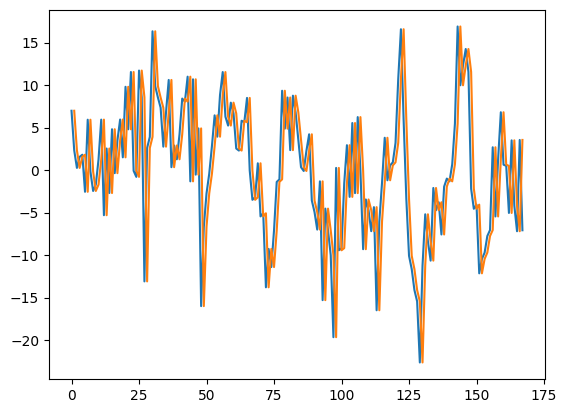

In [91]:
model.resid.plot()
model.resid.shift(1).plot();

2. In the provided OLS regression results, the Durbin-Watson statistic is 0.816. The Durbin-Watson statistic ranges from 0 to 4, with values close to 2 indicating no autocorrelation. Values below 2 suggest positive autocorrelation, while values above 2 suggest negative autocorrelation. In the case of the provided Durbin-Watson statistic of 0.816, it suggests the presence of positive autocorrelation

#### 3. 

In [95]:
residuals = model.resid

# Create the Fourier predictors
t = AnneFrank['time']
x1 = np.cos(2 * np.pi * t / 20)
x2 = np.sin(2 * np.pi * t / 20)
x3 = np.cos(2 * np.pi * t / 30)
x4 = np.sin(2 * np.pi * t / 30)

# Create a DataFrame with the predictors and the residuals
data = pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3, 'x4': x4, 'residuals': residuals})

# Fit the regression model
model_fur_resid = sm.OLS(data['residuals'], data[['x1', 'x2', 'x3', 'x4']]).fit()

# Print the regression results
print(model_fur_resid.summary())


                                 OLS Regression Results                                
Dep. Variable:              residuals   R-squared (uncentered):                   0.273
Model:                            OLS   Adj. R-squared (uncentered):              0.255
Method:                 Least Squares   F-statistic:                              15.36
Date:                Sat, 17 Jun 2023   Prob (F-statistic):                    1.09e-10
Time:                        15:06:05   Log-Likelihood:                         -548.04
No. Observations:                 168   AIC:                                      1104.
Df Residuals:                     164   BIC:                                      1117.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Based on the regression results, the coefficients and their associated p-values indicate the significance of the Fourier predictors in capturing the dominant periodic components in the residuals:

1. Coefficients: The coefficients for the Fourier predictors (x1, x2, x3, and x4) are not zero, indicating that these predictors have an impact on the residuals.

2. P-values: The p-values for the coefficients are all less than 0.05, indicating that they are statistically significant. This suggests that the Fourier predictors (x1, x2, x3, and x4) make a significant contribution to explaining the variation in the residuals.

3. R-squared: The R-squared value of 0.273 indicates that the model with the Fourier predictors explains approximately 27.3% of the variance in the residuals. This is an improvement compared to the initial model, suggesting that the inclusion of the Fourier predictors helps capture a portion of the dominant periodic components.

In conclusion, based on the coefficients, p-values, and improvement in R-squared, it can be deduced that the new model incorporating the Fourier predictors (x1, x2, x3, and x4) makes sense. It suggests that these predictors effectively capture the dominant periodic components with time periods of 20 hours and 30 hours in the residuals.

#### 4. 
To analyze the 1-lag correlation of the residuals of the new model, we need to examine the Durbin-Watson statistic. In the given regression results, the Durbin-Watson value is reported as 1.091. The Durbin-Watson statistic measures the autocorrelation of the residuals by testing for the presence of first-order serial correlation.

In the case of the new model, a Durbin-Watson value close to 2 suggests no significant autocorrelation in the residuals (indicating that the residuals are independent). However, if the Durbin-Watson value is significantly below 2, it indicates positive autocorrelation, while a value above 2 suggests negative autocorrelation.

In this particular case, the Durbin-Watson value of 1.091 suggests the presence of positive autocorrelation in the residuals. This means that there is some level of dependence between adjacent residuals at a lag of 1 in even a greater deal that the model regressed using the previous predictors using a 48 HR cycles.